In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
import seaborn as sn
import datetime
import warnings
import cvxpy as cp
import pypfopt
from pypfopt import risk_models
from pypfopt import plotting
from math import sqrt
from pandas_datareader import data as dt
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import objective_functions, base_optimizer

## **Base de Dados**

In [2]:
# Definindo o dataframe de dados de preço de ativos do portfólio:
precos = pd.DataFrame()

# Definindo o período a ser utilizado
inicio = datetime.datetime(2018, 1, 1)
final = datetime.datetime(2021, 7, 1)

# Definindo os ativos a serem utilizados (Indice BOVESPA):
acoes = ["ABEV3.SA" , "AZUL4.SA" , "B3SA3.SA" , "BBAS3.SA" , "BBDC3.SA",  "BBDC4.SA" , "BBSE3.SA" , "BEEF3.SA", 
"BPAC11.SA", "BRAP4.SA" , "BRDT3.SA" , "BRFS3.SA" , "BRKM5.SA" , "BRML3.SA" , "CCRO3.SA" , "CIEL3.SA" ,
"CMIG4.SA"  ,"COGN3.SA" , "CPFE3.SA" , "CPLE6.SA" , "CRFB3.SA" , "CSAN3.SA" , "CSNA3.SA" , "CVCB3.SA" , "CYRE3.SA" ,
"ECOR3.SA"  ,"EGIE3.SA" , "ELET3.SA" , "ELET6.SA", "EMBR3.SA" , "ENBR3.SA" , "ENEV3.SA" , "ENGI11.SA", "EQTL3.SA" ,
"EZTC3.SA"  ,"FLRY3.SA" , "GGBR4.SA" , "GNDI3.SA" , "GOAU4.SA" , "GOLL4.SA" , "HAPV3.SA" , "HGTX3.SA" , "HYPE3.SA" ,
"IGTA3.SA"  ,"IRBR3.SA" , "ITSA4.SA" , "ITUB4.SA" , "JBSS3.SA" , "JHSF3.SA" , "KLBN11.SA", "LAME4.SA" , "LCAM3.SA" ,
"LREN3.SA"  ,"MGLU3.SA" , "MRFG3.SA" , "MRVE3.SA" , "MULT3.SA" , "NTCO3.SA" , "PCAR3.SA" , "PETR3.SA" , "PETR4.SA" ,
"PRIO3.SA"  ,"QUAL3.SA" , "RADL3.SA" , "RAIL3.SA" , "RENT3.SA" , "SANB11.SA", "SBSP3.SA" , "SULA11.SA", "SUZB3.SA" ,
"TAEE11.SA" , "TOTS3.SA" , "UGPA3.SA" , "USIM5.SA" , "VALE3.SA" , "VIVT3.SA" ,  "WEGE3.SA" ,"YDUQ3.SA"]


for i in acoes:
    precos[i] = dt.get_data_yahoo(i, start = inicio, end = final)['Close']
    
precos.dropna(inplace=True)

In [3]:
sample_cov = risk_models.sample_cov(precos, frequency=252)
sample_cov

,ABEV3.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BBSE3.SA,BEEF3.SA,BPAC11.SA,BRAP4.SA,...,SULA11.SA,SUZB3.SA,TAEE11.SA,TOTS3.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA,YDUQ3.SA
ABEV3.SA,0.179418,0.221708,0.101251,0.136758,0.135967,0.134447,0.081136,0.065835,0.132865,0.077888,...,0.100410,0.045435,0.045142,0.151238,0.161965,0.115729,0.082082,0.070219,0.089610,0.146906
AZUL4.SA,0.221708,0.927587,0.274198,0.352888,0.310863,0.320990,0.165189,0.156976,0.389366,0.189646,...,0.300725,0.087500,0.098806,0.462545,0.385224,0.334637,0.216811,0.129863,0.199065,0.372224
B3SA3.SA,0.101251,0.274198,0.255831,0.187344,0.168465,0.161766,0.111941,0.090446,0.234702,0.125613,...,0.158753,0.039854,0.057032,0.193416,0.210708,0.169876,0.135932,0.080615,0.090650,0.172059
BBAS3.SA,0.136758,0.352888,0.187344,0.295301,0.248582,0.249439,0.137232,0.083803,0.256435,0.134942,...,0.170845,0.026184,0.065599,0.148246,0.252872,0.212058,0.152235,0.086729,0.092799,0.204517
BBDC3.SA,0.135967,0.310863,0.168465,0.248582,0.249405,0.246844,0.127736,0.074251,0.233485,0.132607,...,0.148783,0.023499,0.058200,0.081243,0.228294,0.183783,0.143608,0.087523,0.079663,0.183181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USIM5.SA,0.115729,0.334637,0.169876,0.212058,0.183783,0.180699,0.105665,0.099143,0.228556,0.204792,...,0.158841,0.095082,0.045930,0.155685,0.229721,0.440855,0.213758,0.061421,0.145043,0.189252
VALE3.SA,0.082082,0.216811,0.135932,0.152235,0.143608,0.141287,0.079886,0.104947,0.172741,0.222584,...,0.115406,0.086551,0.036930,0.080325,0.181201,0.213758,0.246384,0.067371,0.107122,0.112234
VIVT3.SA,0.070219,0.129863,0.080615,0.086729,0.087523,0.084592,0.054759,0.058037,0.105395,0.062703,...,0.067274,0.033624,0.041862,-0.051052,0.126243,0.061421,0.067371,0.139599,0.046635,0.086444
WEGE3.SA,0.089610,0.199065,0.090650,0.092799,0.079663,0.063732,0.024759,0.096617,0.005293,0.116374,...,0.126895,0.100802,0.033536,0.265051,0.149486,0.145043,0.107122,0.046635,2.977000,0.093366


**Return estimation**


In [4]:
# Calculando retornos esperados e covariancias

mu = expected_returns.capm_return(precos)
S = risk_models.CovarianceShrinkage(precos).ledoit_wolf()

In [5]:
from pypfopt.efficient_frontier import EfficientFrontier

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()

In [6]:
cleaned_weights = ef.clean_weights()
ef.save_weights_to_file("weights.txt")  # saves to file
print(cleaned_weights)

OrderedDict([('ABEV3.SA', 0.01115), ('AZUL4.SA', 0.01634), ('B3SA3.SA', 0.01283), ('BBAS3.SA', 0.01352), ('BBDC3.SA', 0.01311), ('BBDC4.SA', 0.01287), ('BBSE3.SA', 0.00915), ('BEEF3.SA', 0.01137), ('BPAC11.SA', 0.01475), ('BRAP4.SA', 0.01111), ('BRDT3.SA', 0.0127), ('BRFS3.SA', 0.01331), ('BRKM5.SA', 0.01539), ('BRML3.SA', 0.01322), ('CCRO3.SA', 0.01352), ('CIEL3.SA', 0.01326), ('CMIG4.SA', 0.01358), ('COGN3.SA', 0.01483), ('CPFE3.SA', 0.01104), ('CPLE6.SA', 0.01344), ('CRFB3.SA', 0.00996), ('CSAN3.SA', 0.01335), ('CSNA3.SA', 0.01416), ('CVCB3.SA', 0.01474), ('CYRE3.SA', 0.01592), ('ECOR3.SA', 0.01488), ('EGIE3.SA', 0.00933), ('ELET3.SA', 0.01533), ('ELET6.SA', 0.01338), ('EMBR3.SA', 0.0134), ('ENBR3.SA', 0.01028), ('ENEV3.SA', 0.01217), ('ENGI11.SA', 0.01136), ('EQTL3.SA', 0.01131), ('EZTC3.SA', 0.0147), ('FLRY3.SA', 0.01016), ('GGBR4.SA', 0.01345), ('GNDI3.SA', 0.01386), ('GOAU4.SA', 0.01427), ('GOLL4.SA', 0.01558), ('HAPV3.SA', 0.01228), ('HGTX3.SA', 0.01364), ('HYPE3.SA', 0.01251),

In [7]:
ef.portfolio_performance(verbose=True)

Expected annual return: 20.7%
Annual volatility: 38.1%
Sharpe Ratio: 0.49


(0.20658965183163483, 0.38059085463630465, 0.49026309896474324)

In [8]:
from pypfopt import objective_functions

ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=10)
w = ef.max_sharpe()
print(ef.clean_weights())

OrderedDict([('ABEV3.SA', 0.00909), ('AZUL4.SA', 0.02308), ('B3SA3.SA', 0.01219), ('BBAS3.SA', 0.01415), ('BBDC3.SA', 0.01272), ('BBDC4.SA', 0.01264), ('BBSE3.SA', 0.00774), ('BEEF3.SA', 0.00794), ('BPAC11.SA', 0.01614), ('BRAP4.SA', 0.0093), ('BRDT3.SA', 0.01319), ('BRFS3.SA', 0.01105), ('BRKM5.SA', 0.01688), ('BRML3.SA', 0.01465), ('CCRO3.SA', 0.01465), ('CIEL3.SA', 0.01283), ('CMIG4.SA', 0.01244), ('COGN3.SA', 0.01656), ('CPFE3.SA', 0.00939), ('CPLE6.SA', 0.01174), ('CRFB3.SA', 0.00659), ('CSAN3.SA', 0.01247), ('CSNA3.SA', 0.01438), ('CVCB3.SA', 0.0208), ('CYRE3.SA', 0.01815), ('ECOR3.SA', 0.01562), ('EGIE3.SA', 0.00732), ('ELET3.SA', 0.01549), ('ELET6.SA', 0.01347), ('EMBR3.SA', 0.01466), ('ENBR3.SA', 0.00855), ('ENEV3.SA', 0.01042), ('ENGI11.SA', 0.00996), ('EQTL3.SA', 0.00932), ('EZTC3.SA', 0.01654), ('FLRY3.SA', 0.00917), ('GGBR4.SA', 0.01343), ('GNDI3.SA', 0.01315), ('GOAU4.SA', 0.01398), ('GOLL4.SA', 0.023), ('HAPV3.SA', 0.01199), ('HGTX3.SA', 0.01569), ('HYPE3.SA', 0.01016), 

/opt/anaconda3/lib/python3.8/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:252: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


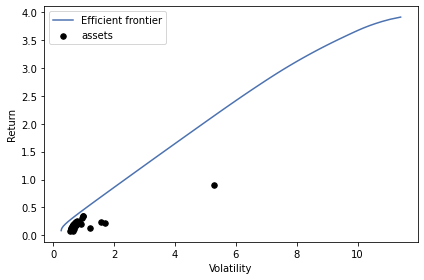

In [9]:
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.add_constraint(lambda w: w[0] >= 0.2)
ef.add_constraint(lambda w: w[2] == 0.15)
ef.add_constraint(lambda w: w[3] + w[4] <= 0.10)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()

ValueError: Weights is None

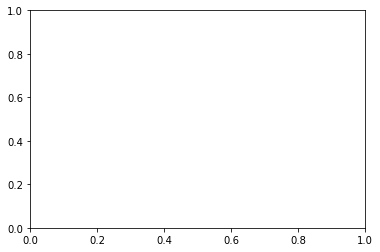

In [12]:
# 100 portfolios with risks between 0.10 and 0.30
risk_range = np.linspace(0.10, 0.40, 100)
plotting.plot_efficient_frontier(ef, ef_param="risk", ef_param_range=risk_range, show_assets=True, showfig=True)

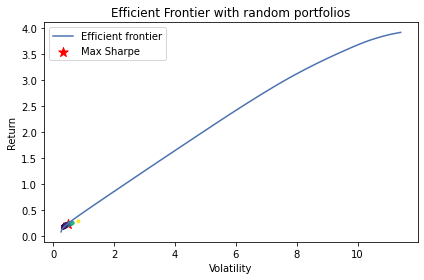

In [13]:
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()